## The Title: "A/B test for an online shop"

### The Context: <br><br>For a big online store, the marketing department tested a new feature for the website that may boost revenue.<br>I need to analyze the results for an A/B test for an online store and provide conclusions.

### Description of the data:
### `orders.csv`
* *transactionId* — order identifier
* *visitorId* — identifier of the user who placed the order
* *date* — of the order
* *revenue* — from the order
* *group* — the A/B test group that the user belongs to

### `visits.csv`
* *date* — date
* *group* — A/B test group
* *visits* — the number of visits on the date specified in the A/B test group specified

## Decomposition:

### Validate the original datasets on mistakes
*some of the visitors might have gotten into both group A and group B and so on*

### Analyze the A/B test:

1. Graph cumulative revenue by group. Make conclusions and conjectures.
2. Graph cumulative average order size by group. Make conclusions andconjectures.
3. Graph the relative difference in cumulative average order size for group Bcompared with group A. Make conclusions and conjectures.
4. Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and make conjectures.
5. Plot a scatter chart of the number of orders per user. Make conclusions and conjectures.
6. Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.
7. Plot a scatter chart of order prices. Make conclusions and conjectures.
8. Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.
9. Find the statistical significance of the difference in conversion between the groups using the raw data. Make conclusions and conjectures.
10. Find the statistical significance of the difference in average order size between the groups using the raw data. Make conclusions and conjectures.
11. Find the statistical significance of the difference in conversion between the groups using the filtered data. Make conclusions and conjectures.
12. Find the statistical significance of the difference in average order size between the groups using the filtered data. Make conclusions and conjectures.
13. Make a decision based on the test results. The possible decisions are:
    * Stop the test, consider one of the groups the leader.
    * Stop the test, conclude that there is no difference between the groups.
    * Continue the test.

### Processing

In [1]:
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pandas as pd
pd.set_option('max_colwidth', 400)


%matplotlib inline

sns.set_style('whitegrid')

In [2]:
alpha = .05

In [3]:
rotation = 15

In [4]:
visits = pd.read_csv('visits.csv'
                     , sep=','
                    ,parse_dates=['date'])
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [5]:
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.8 KB


In [6]:
orders = pd.read_csv('orders.csv'
                   , sep=','
                     ,parse_dates=['date']
                   )
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [7]:
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 110.0 KB


In [8]:
orders.columns = orders.columns.str.lower()

## A/B Test Analysis

> **! I've excluded duplicated users from the dataset.  
This step helped to exclude a lot of "noise" in the data, e.g., number of orders, and so on.**

### Verification, that users are not doubled in groups

In [9]:
orders.head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [10]:
orders['group'].unique()

array(['B', 'A'], dtype=object)

In [11]:
orders[orders['group']=='A']['visitorid'].head()

2     4069496402
7       78758296
8      295230930
10     879864040
12    3213223594
Name: visitorid, dtype: int64

In [12]:
pd.DataFrame({'duplicated_visitorid':list(set(
    orders[orders['group']=='A']['visitorid']
        )
                                          .intersection(
                                              orders[orders['group']=='B']['visitorid']
                                          ))}).head()

,duplicated_visitorid
0,3957174400
1,3984495233
2,2780786433
3,1294878855
4,1648269707


In [13]:
duplicated = pd.DataFrame({'duplicated_visitorid':list(set(
    orders[orders['group']=='A']['visitorid']
        )
                                          .intersection(
                                              orders[orders['group']=='B']['visitorid']
                                          ))})

In [14]:
duplicated.shape[0]

58

In [15]:
orders.loc[~orders['visitorid'].isin(duplicated['duplicated_visitorid'])].head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [16]:
orders = orders.loc[~orders['visitorid'].isin(duplicated['duplicated_visitorid'])]

In [17]:
set(orders[orders['group']=='B']['date'])==set(orders[orders['group']=='A']['date'])

True

> **We have measures for the same list of dates in both groups.<br> So I've decided to use the approach and proceed with them as a "whole table" instead of separating them onto different dataframes according to the group and only after that merging.**

### Graph cumulative revenue by group. Make conclusions and conjectures.

In [18]:
orders.head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [19]:
orders.groupby(['group','date']).agg({ 'revenue':'sum'
    ,'transactionid':'count', 'visitorid':'nunique'     }).sample(10)

revenue  transactionid  visitorid
group date                                         
A     2019-08-18    965.6             13         13
      2019-08-17    548.5              6          5
B     2019-08-30   3286.8             21         21
A     2019-08-26   2464.8             16         16
B     2019-08-20   2324.6             20         20
      2019-08-14   1692.4             14         14
      2019-08-06   3369.3             23         22
      2019-08-12   1657.8             19         19
      2019-08-17   1276.0             13         13
      2019-08-11    855.4             12         12

In [20]:
df = orders.groupby(['group','date']).agg({ 'revenue':'sum'
    ,'transactionid':'count', 'visitorid':'nunique'     })

In [21]:
df.groupby('group').cumsum(axis=0).sample(10)

revenue  transactionid  visitorid
group date                                         
A     2019-08-24  40321.3            372        362
B     2019-08-11  20959.0            210        207
A     2019-08-12  20533.7            200        192
B     2019-08-10  20103.6            198        195
      2019-08-29  74576.7            510        506
      2019-08-04   6138.5             68         66
A     2019-08-02   3734.9             42         37
B     2019-08-09  18428.8            176        173
      2019-08-14  26183.7            263        260
      2019-08-19  56749.6            348        344

In [22]:
df_cum = df.groupby('group').cumsum(axis=0)

In [23]:
df_cum['avg_order'] = df_cum['revenue'] / df_cum['transactionid']

In [24]:
df_cum.columns

Index(['revenue', 'transactionid', 'visitorid', 'avg_order'], dtype='object')

In [25]:
df_cum.columns = ['cum_revenue', 'cum_transactions', 'cum_unique_visitors','cum_avg_order']

In [26]:
df_cum = df_cum.reset_index()

In [27]:
df_cum.head()

,group,date,cum_revenue,cum_transactions,cum_unique_visitors,cum_avg_order
0,A,2019-08-01,2266.6,23,19,98.547826
1,A,2019-08-02,3734.9,42,37,88.926190
2,A,2019-08-03,5550.1,66,61,84.092424
3,A,2019-08-04,6225.6,77,72,80.851948
4,A,2019-08-05,7623.6,99,94,77.006061


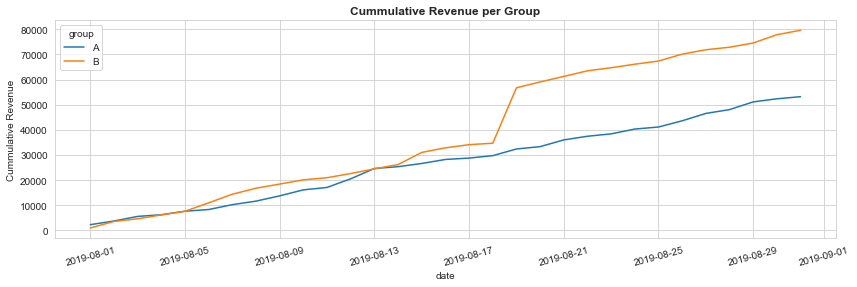

In [28]:
plt.figure(figsize=(14,4))

sns.lineplot(

x="date"
    , y="cum_revenue",
                  hue="group"
    
                  ,data=df_cum
)

plt.xticks(rotation=rotation)

plt.ylabel("Cummulative Revenue")

plt.title('Cummulative Revenue per Group',fontweight="bold")
plt.show()

> The revenue is rising steadily throughout the whole test. <br>
The sharp increase could be provided by two factors: or "big deal" or "big amount of deals". I'll investigate it later.

## Graph cumulative average order size by group. Make conclusions and conjectures

In [29]:
orders['revenue'].sum() / orders['transactionid'].nunique()

130.77086614173228

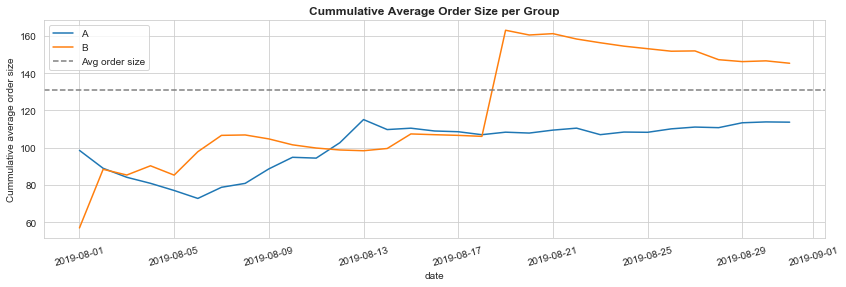

In [30]:
plt.figure(figsize=(14,4))

sns.lineplot(

x="date"
    , y="cum_avg_order",
                  hue="group"
    
                  ,data=df_cum
)

#plt.margins(x=0)


plt.axhline(orders['revenue'].sum() / orders['transactionid'].nunique()
           ,color='grey', linestyle='--', label ='Avg order size'
           )

plt.legend()

plt.xticks(rotation=rotation)

plt.ylabel("Cummulative average order size")

plt.title('Cummulative Average Order Size per Group',fontweight="bold")
plt.show()

> Cumulative overage order size becomes steady by the end of the test with a slightly negative slope for B. 
<br> The surge in group B may have been due to the presence of large, expensive orders.

###  Relative difference in cumulativeRevenue for group B compared with group A

In [31]:
df_cum.head()

,group,date,cum_revenue,cum_transactions,cum_unique_visitors,cum_avg_order
0,A,2019-08-01,2266.6,23,19,98.547826
1,A,2019-08-02,3734.9,42,37,88.926190
2,A,2019-08-03,5550.1,66,61,84.092424
3,A,2019-08-04,6225.6,77,72,80.851948
4,A,2019-08-05,7623.6,99,94,77.006061


In [32]:
df_rd = df_cum.groupby('date').agg(
    lambda x: x.iloc[1]/x.iloc[0]-1
)

In [33]:
df_rd = df_rd.add_suffix('_rd')

In [34]:
df_rd.head()

,cum_revenue_rd,cum_transactions_rd,cum_unique_visitors_rd,cum_avg_order_rd
date,,,,
2019-08-01,-0.573282,-0.260870,-0.105263,-0.422675
2019-08-02,-0.053442,-0.047619,0.054054,-0.006114
2019-08-03,-0.169943,-0.181818,-0.131148,0.014514
2019-08-04,-0.013991,-0.116883,-0.083333,0.116511
2019-08-05,-0.004696,-0.101010,-0.074468,0.107136


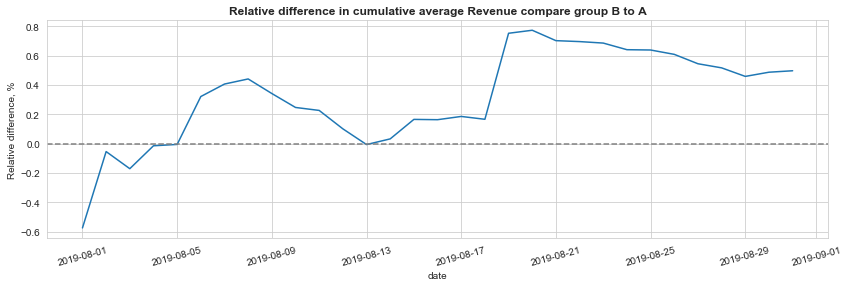

In [35]:
plt.figure(figsize=(14, 4))

sns.lineplot(

    x=df_rd.index, y="cum_revenue_rd", data=df_rd
)

plt.axhline(0, color='grey', linestyle='--')

plt.xticks(rotation=rotation)
plt.ylabel("Relative difference, %")
plt.title('Relative difference in cumulative average Revenue compare group B to A',
          fontweight="bold")
plt.show()

> At several points, the difference between the segments spikes. <br>This means there could be some outliers from big orders or a big amount of orders at the same moment.

###  Graph the relative difference in cumulative average order size for group B compared with group A. Make conclusions and conjectures.

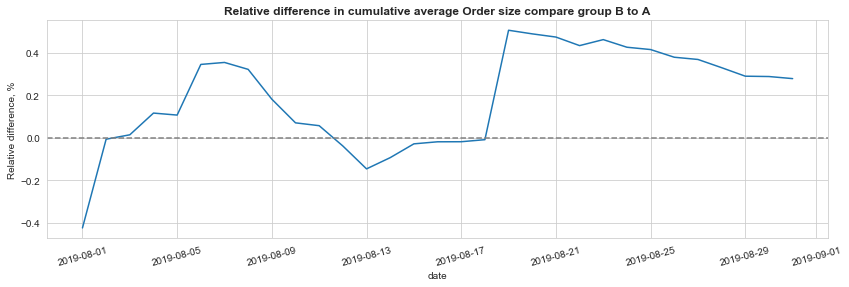

In [36]:
plt.figure(figsize=(14, 4))

sns.lineplot(

    x=df_rd.index, y="cum_avg_order_rd", data=df_rd
)


plt.axhline(0, color='grey', linestyle='--')

plt.xticks(rotation=rotation)
plt.ylabel('Relative difference, %')
plt.title('Relative difference in cumulative average Order size compare group B to A', fontweight="bold")
plt.show()

> At several points, the difference between the segments spikes. This means there must be some big orders and outliers.<br>
The graph itself very similar to the previous one about Revenue.<br>
It could mean that the number of orders is stable enough and the point is in big revenues.

### Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw  conclusions and make conjectures.

In [37]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [38]:
visits['group'].value_counts(dropna=False)

A    31
B    31
Name: group, dtype: int64

In [39]:
orders.head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [40]:
orders.groupby(['date','group'])['transactionid'].nunique().reset_index().head()

,date,group,transactionid
0,2019-08-01,A,23
1,2019-08-01,B,17
2,2019-08-02,A,19
3,2019-08-02,B,23
4,2019-08-03,A,24


In [41]:
orders_daily = orders.groupby(['date','group'])['transactionid'].nunique().reset_index()

In [42]:
orders_daily.columns

Index(['date', 'group', 'transactionid'], dtype='object')

In [43]:
orders_daily.columns = ['date', 'group', 'orders']

In [44]:
pd.merge(orders_daily, visits, on=['group','date']).sample(10)

,date,group,orders,visits
8,2019-08-05,A,22,756
4,2019-08-03,A,24,507
43,2019-08-22,B,21,650
47,2019-08-24,B,14,378
39,2019-08-20,B,20,560
1,2019-08-01,B,17,713
6,2019-08-04,A,11,717
24,2019-08-13,A,14,748
54,2019-08-28,A,15,594
22,2019-08-12,A,19,595


In [45]:
conversion = pd.merge(orders_daily, visits, on=['group','date'])

In [46]:
conversion['rate'] = conversion['orders']/conversion['visits']

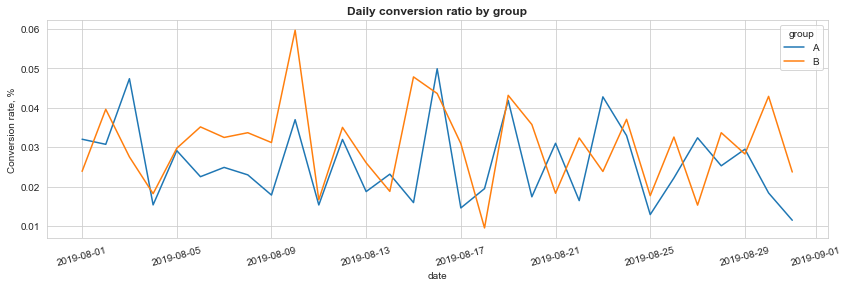

In [47]:
plt.figure(figsize=(14, 4))

sns.lineplot(

    x='date', y="rate", hue="group", data=conversion
)

plt.xticks(rotation=rotation)
plt.ylabel('Conversion rate, %')
plt.title('Daily conversion ratio by group', fontweight="bold")
plt.show()

> **I've decided to proceed with cumulative metrics because here we have huge volatility.**

In [48]:
conversion_cum = pd.merge(orders_daily, visits, on=['group','date'])

In [49]:
conversion_cum.groupby(['group','date']).agg({ 'orders':'sum'
    ,'visits':'sum'}).sample(10)

orders  visits
group date                      
A     2019-08-20      10     575
      2019-08-22      10     609
      2019-08-06      15     667
B     2019-08-02      23     581
      2019-08-13      20     769
A     2019-08-13      14     748
      2019-08-03      24     507
      2019-08-07      16     644
      2019-08-10      15     406
      2019-08-01      23     719

In [50]:
conversion_cum.groupby(['group','date']).agg({ 'orders':'sum'
    ,'visits':'sum'}).groupby('group').cumsum(axis=0)

orders  visits
group date                      
A     2019-08-01      23     719
      2019-08-02      42    1338
      2019-08-03      66    1845
      2019-08-04      77    2562
      2019-08-05      99    3318
...                  ...     ...
B     2019-08-27     473   16523
      2019-08-28     495   17177
      2019-08-29     510   17708
      2019-08-30     531   18198
      2019-08-31     548   18916

[62 rows x 2 columns]

In [51]:
conversion_cum = conversion_cum.groupby(['group','date']).agg({ 'orders':'sum'
    ,'visits':'sum'}).groupby('group').cumsum(axis=0)

In [52]:
conversion_cum = conversion_cum.add_suffix('_cum')

In [53]:
conversion_cum['ratio_cum'] = conversion_cum['orders_cum'] / conversion_cum['visits_cum']

In [54]:
conversion_cum = conversion_cum.reset_index()

In [55]:
conversion['orders'].sum() / conversion['visits'].sum()

0.026983958355465847

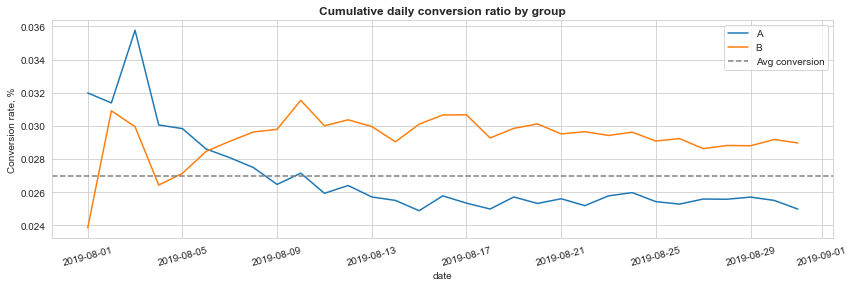

In [56]:
plt.figure(figsize=(14,4))

sns.lineplot(

x='date'
    , y="ratio_cum"
                 , hue="group"
    
                  ,data=conversion_cum
)

plt.axhline(conversion['orders'].sum() / conversion['visits'].sum()
           ,color='grey', linestyle='--', label ='Avg conversion'
           )

plt.legend()

plt.xticks(rotation=rotation)
plt.ylabel('Conversion rate, %')
plt.title('Cumulative daily conversion ratio by group',fontweight="bold")
plt.show()

> The cumulative daily conversion ratio of B arose and consolidated.<br>
It is constantly higher than A.

###  Relative difference in cumulative daily convertion ratio for group B compared with group A

In [57]:
conversion_cum.groupby(['date']).agg(
    lambda x: x.iloc[1]/x.iloc[0]-1
).head()

,orders_cum,visits_cum,ratio_cum
date,,,
2019-08-01,-0.260870,-0.008345,-0.254650
2019-08-02,-0.047619,-0.032885,-0.015235
2019-08-03,-0.181818,-0.022764,-0.162759
2019-08-04,-0.116883,0.004294,-0.120659
2019-08-05,-0.101010,-0.011453,-0.090595


In [58]:
conversion_cum_rd = conversion_cum.groupby(['date']).agg(
    lambda x: x.iloc[1]/x.iloc[0]-1
)

In [59]:
conversion_cum_rd = conversion_cum_rd.add_suffix('_rd')

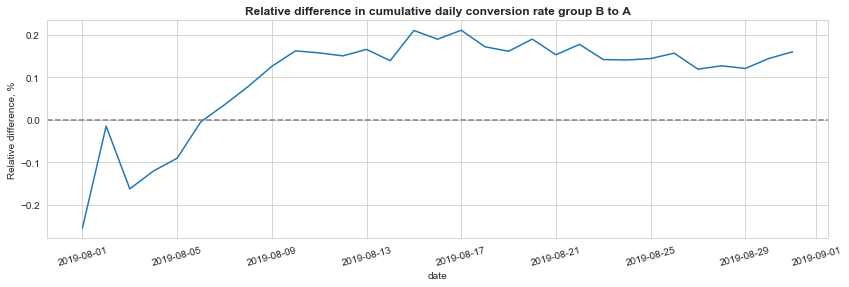

In [60]:
plt.figure(figsize=(14,4))

sns.lineplot(

x=conversion_cum_rd.index
    , y="ratio_cum_rd"
                 #, hue="group"
    
                  ,data=conversion_cum_rd
)

#plt.margins(x=0)

plt.axhline(0, color='grey', linestyle='--')

plt.xticks(rotation=rotation)
plt.ylabel('Relative difference, %')
plt.title('Relative difference in cumulative daily conversion rate group B to A',fontweight="bold")
plt.show()

> We can see on the graph, that the difference in cumulative daily conversion ratio is steady, and the delta B to A is high enough.

### Cumulative visits by group and Relative difference in cumulative visits for group B compared with group A

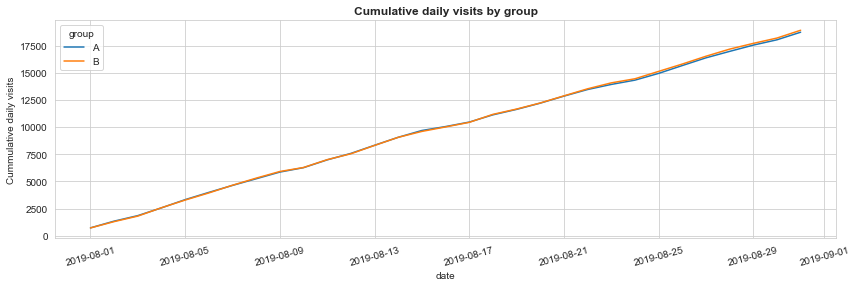

In [61]:
plt.figure(figsize=(14,4))

sns.lineplot(

x='date'
    , y="visits_cum"
                 , hue="group"
    
                  ,data=conversion_cum
)

plt.xticks(rotation=rotation)
plt.ylabel('Cummulative daily visits')
plt.title('Cumulative daily visits by group',fontweight="bold")
plt.show()

> The number of users was constantly rising through the test. <br>It means we've provided consistency for the experiment.

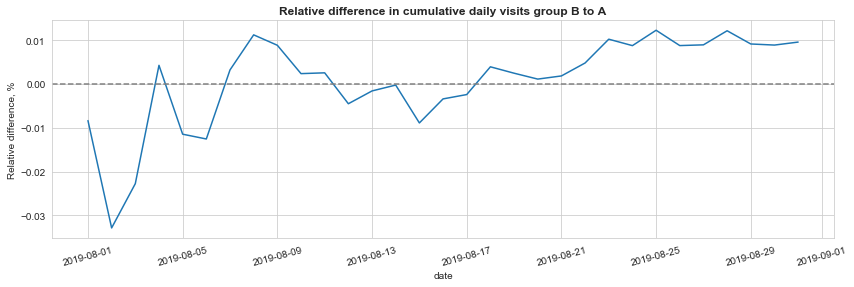

In [62]:
plt.figure(figsize=(14, 4))

sns.lineplot(

    x=conversion_cum_rd.index, y="visits_cum_rd", data=conversion_cum_rd
)


plt.axhline(0, color='grey', linestyle='--')

plt.xticks(rotation=rotation)
plt.ylabel('Relative difference, %')
plt.title('Relative difference in cumulative daily visits group B to A',
          fontweight="bold")
plt.show()

> The divergence is tiny.<br> Hence both groups filled up about simultaneously, and the experiment was provided correctly.

### Plot a scatter chart of the number of orders per user. Make conclusions and conjectures.

In [63]:
orders.head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [64]:
orders.groupby('visitorid')['transactionid'].nunique().sort_values(ascending=False).head()

visitorid
249864742     3
3908431265    3
2742574263    3
3967698036    3
611059232     3
Name: transactionid, dtype: int64

In [65]:
orders_by_user = orders.groupby('visitorid')['transactionid'].nunique().reset_index()

In [66]:
orders_by_user.columns = ['visitorid', 'orders']

In [67]:
orders_by_user.head()

,visitorid,orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


In [68]:
orders_by_user.describe()

,visitorid,orders
count,9.730000e+02,973.000000
mean,2.118387e+09,1.044193
std,1.221446e+09,0.238090
min,5.114589e+06,1.000000
25%,1.028756e+09,1.000000
50%,2.138109e+09,1.000000
75%,3.141508e+09,1.000000
max,4.283872e+09,3.000000


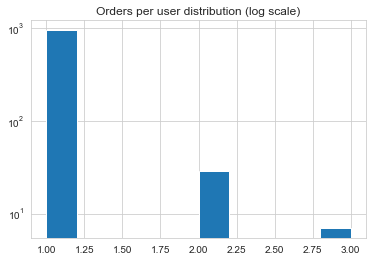

In [174]:
orders_by_user['orders'].hist(log=True)
plt.title('Orders per user distribution (log scale)')
plt.show()

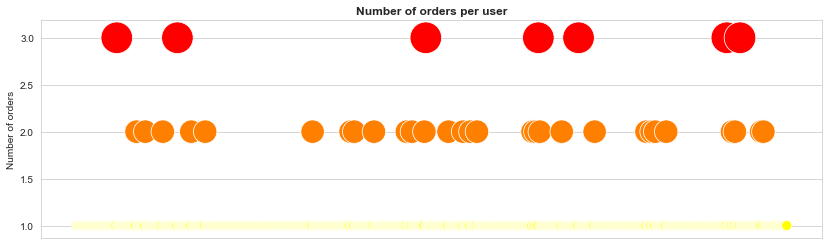

In [70]:
plt.figure(figsize=(14, 4))

ax = sns.scatterplot(x=orders_by_user.index, y="orders", data=orders_by_user, hue="orders"
                     , size="orders", sizes=(100, 1000), palette='autumn_r', legend=False
                     )
ax.grid(axis='x')

plt.title('Number of orders per user', fontweight="bold")
plt.xticks(visible=False, rotation=rotation)

plt.ylabel('Number of orders')
plt.show()

> We have the case of an online store. <br> As was described on lesson's materials for an online store with steady demand, the typical user makes no more than two orders within a short period. 
<br> Here we can clearly notice that only a few orders were more than 2.

### Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.

In [71]:
np.percentile(orders_by_user['orders'], [95, 99])

array([1., 2.])

In [72]:
orders_lim = np.percentile(orders_by_user['orders'], [99])[0].astype(int)

In [73]:
print('From here I set the border point for anomalies as {} orders'
      .format(orders_lim))

From here I set the border point for anomalies as 2 orders


### Plot a scatter chart of order prices. Make conclusions and conjectures.

In [74]:
orders.head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [75]:
orders['revenue'].describe()

count     1016.000000
mean       130.770866
std        648.079810
min          5.000000
25%         20.775000
50%         50.100000
75%        126.950000
max      19920.400000
Name: revenue, dtype: float64

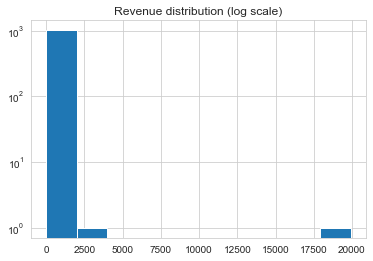

In [173]:
orders['revenue'].hist(log=True)
plt.title('Revenue distribution (log scale)')
plt.show()

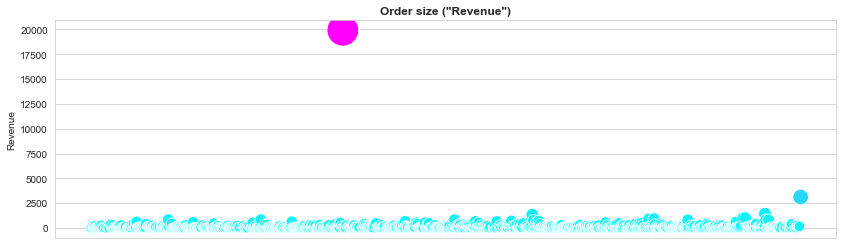

In [77]:
plt.figure(figsize=(14, 4))

ax = sns.scatterplot(x=orders.index, y="revenue", data=orders, hue="revenue"
                     , size="revenue", sizes=(100, 1000), palette='cool', legend=False
                     )
ax.grid(axis='x')

plt.title('Order size ("Revenue")', fontweight="bold")
plt.xticks(visible=False, rotation=rotation)

plt.ylabel('Revenue')
plt.show()

> *Looks like a sunset on the sea =)*

> We can clearly see one extreme outlier about 20000,  that could affect lots of indicators. <br> The next one is around 2500.

### Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.

In [78]:
np.percentile(orders['revenue'], [95, 99])

array([414.275, 830.3  ])

In [79]:
revenue_lim = np.percentile(orders['revenue'], [99])[0].astype(int)

In [80]:
print('From here I set the border point for anomalies as {} for revenue'
      .format(revenue_lim))

From here I set the border point for anomalies as 830 for revenue


> Not more than 5% of users placed an order for more than 414, and 1% of users made more than 830.<br> Thus, it would be reasonable to set it as the lower limit by this value.

### Find the statistical significance of the difference in conversion between the groups using the raw data. Make conclusions and conjectures.

<font color="green">
    The Null Hypothesis here is that the average conversion rate in group A is equal to the average conversion rate in group B for the raw data.

</font>

In [81]:
conversion.head()

,date,group,orders,visits,rate
0,2019-08-01,A,23,719,0.031989
1,2019-08-01,B,17,713,0.023843
2,2019-08-02,A,19,619,0.030695
3,2019-08-02,B,23,581,0.039587
4,2019-08-03,A,24,507,0.047337


In [82]:
conversion['zero_orders'] = conversion['visits'] - conversion['orders']

In [83]:
conversion.head()

,date,group,orders,visits,rate,zero_orders
0,2019-08-01,A,23,719,0.031989,696
1,2019-08-01,B,17,713,0.023843,696
2,2019-08-02,A,19,619,0.030695,600
3,2019-08-02,B,23,581,0.039587,558
4,2019-08-03,A,24,507,0.047337,483


In [84]:
orders.groupby(['group','date','visitorid'])['transactionid'].nunique().reset_index().head()

,group,date,visitorid,transactionid
0,A,2019-08-01,381340408,1
1,A,2019-08-01,572335325,1
2,A,2019-08-01,611059232,3
3,A,2019-08-01,678354126,1
4,A,2019-08-01,821846484,1


In [85]:
purchase_history = orders.groupby(['group','date','visitorid'])['transactionid'].nunique().reset_index()

In [86]:
purchase_history.columns = ['group', 'date', 'visitorid', 'orders']

In [87]:
purchase_history[purchase_history['group']=='A']['orders'].head()

0    1
1    1
2    3
3    1
4    1
Name: orders, dtype: int64

In [88]:
pd.Series(0,np.arange(conversion[conversion['group']=='A']['zero_orders'].sum())).head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

> **Due to no option to match by UID visitors and buyers, I'll use the assumption that all the visitors are unique.**

In [89]:
pd.concat([
    purchase_history[purchase_history['group']=='A']['orders']
           ,pd.Series(0,np.arange(conversion[conversion['group']=='A']['zero_orders'].sum()), name='orders')                     
                            ],axis=0).head(10)

0    1
1    1
2    3
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: orders, dtype: int64

In [90]:
sample_a_conv = pd.concat([
    purchase_history[purchase_history['group']=='A']['orders']
           ,pd.Series(0,np.arange(conversion[conversion['group']=='A']['zero_orders'].sum()), name='orders')                     
                            ],axis=0)

In [91]:
sample_b_conv = pd.concat([
    purchase_history[purchase_history['group']=='B']['orders']
           ,pd.Series(0,np.arange(conversion[conversion['group']=='B']['zero_orders'].sum()), name='orders')                     
                            ],axis=0)

In [92]:
sample_a_conv.unique()

array([1, 3, 2, 0], dtype=int64)

In [93]:
sample_b_conv.unique()

array([1, 2, 0], dtype=int64)

In [94]:
st.mannwhitneyu(sample_a_conv, sample_b_conv)[1]

0.004363883823701027

In [95]:
p_conv = st.mannwhitneyu(sample_a_conv, sample_b_conv)[1]

In [96]:
sample_b_conv.mean()/sample_a_conv.mean()-1

0.15936202944451683

In [97]:
if (p_conv < alpha):
    print("Null hypothesis rejected: the difference is statistically significant")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference")

Null hypothesis rejected: the difference is statistically significant


In [98]:
print('For the raw data with {:.0%}confidence the difference in conversion between group B to A is about:{:.0%}'.format(1-alpha,sample_b_conv.mean()/sample_a_conv.mean()-1))

For the raw data with 95%confidence the difference in conversion between group B to A is about:16%


### Find the statistical significance of the difference in average order size between the groups using the raw data. Make conclusions and conjectures.

> <font color="green">
    The Null Hypothesis here is that the average order size in group A is equal to the average order size in group B for the raw data.

</font>

In [99]:
orders.head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [100]:
orders[orders['group']=='A']['revenue'].head()

7      20.1
8     215.9
10     65.7
12    115.4
14    170.9
Name: revenue, dtype: float64

In [101]:
sample_a_rev = orders[orders['group']=='A']['revenue']

In [102]:
sample_b_rev = orders[orders['group']=='B']['revenue']

In [103]:
st.mannwhitneyu(sample_a_rev, sample_b_rev)[1]

0.4311164845007834

In [104]:
p_rev = st.mannwhitneyu(sample_a_rev, sample_b_rev)[1]

In [105]:
sample_b_rev.mean()/sample_a_rev.mean()-1

0.2783448769307848

In [106]:
if (p_rev < alpha):
    print("Null hypothesis rejected: the difference is statistically significant")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference")

Failed to reject the null hypothesis: we can't make conclusions about the difference


### Find the statistical significance of the difference in conversion between the groups using the filtered data. Make conclusions and conjectures.

> <font color="green">
    The Null Hypothesis here is that the average conversion rate in group A is equal to the average conversion rate in group B for the filtered data (after excluding outliers by the order size and the amount of orders)

</font>

In [107]:
orders.head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [108]:
orders_lim

2

In [109]:
revenue_lim

830

In [110]:
orders_by_user.head()

,visitorid,orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


In [111]:
users_expensive_orders = orders.query('revenue>@revenue_lim')[['visitorid']]

In [112]:
users_expensive_orders.head()

,visitorid
131,2254586615
287,2254456485
425,1920142716
613,3931967268
743,4133034833


In [113]:
users_expensive_orders.shape[0]

12

In [114]:
users_many_orders = orders_by_user[orders_by_user['orders']>orders_lim][['visitorid']]

In [115]:
users_many_orders.head()

,visitorid
55,249864742
138,611059232
478,2108163459
632,2742574263
687,2988190573


In [116]:
users_many_orders.shape[0]

7

In [117]:
abnormal_users = pd.concat([users_expensive_orders, users_many_orders], axis=0)

In [118]:
abnormal_users = abnormal_users.drop_duplicates()

In [119]:
abnormal_users.head()

,visitorid
131,2254586615
287,2254456485
425,1920142716
613,3931967268
743,4133034833


In [120]:
abnormal_users.shape[0]

19

In [121]:
orders.loc[~orders['visitorid'].isin(abnormal_users['visitorid'])].head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [122]:
orders_filtered = orders.loc[~orders['visitorid'].isin(abnormal_users['visitorid'])]

In [123]:
orders_filtered.shape[0]

983

In [124]:
orders_filtered.head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [125]:
orders_filtered.groupby(['date','group'])['transactionid'].nunique().reset_index().head()

,date,group,transactionid
0,2019-08-01,A,18
1,2019-08-01,B,17
2,2019-08-02,A,18
3,2019-08-02,B,23
4,2019-08-03,A,24


In [126]:
orders_daily_filtered = orders_filtered.groupby(['date','group'])['transactionid'].nunique().reset_index()

In [127]:
orders_daily_filtered.columns

Index(['date', 'group', 'transactionid'], dtype='object')

In [128]:
orders_daily_filtered.columns = ['date', 'group', 'orders']

In [171]:
pd.merge(orders_daily_filtered, visits, on=['group','date']).sample(10)

,date,group,orders,visits
20,2019-08-11,A,11,718
35,2019-08-18,B,7,737
29,2019-08-15,B,24,544
45,2019-08-23,B,13,546
19,2019-08-10,B,22,369
26,2019-08-14,A,17,735
59,2019-08-30,B,21,490
51,2019-08-26,B,22,676
56,2019-08-29,A,17,577
8,2019-08-05,A,22,756


In [130]:
coversion_filtered = pd.merge(orders_daily_filtered, visits, on=['group','date'])

In [131]:
coversion_filtered['zero_orders'] = coversion_filtered['visits'] - coversion_filtered['orders']

In [132]:
coversion_filtered.head()

,date,group,orders,visits,zero_orders
0,2019-08-01,A,18,719,701
1,2019-08-01,B,17,713,696
2,2019-08-02,A,18,619,601
3,2019-08-02,B,23,581,558
4,2019-08-03,A,24,507,483


In [169]:
orders_filtered.groupby(['group','date','visitorid'])['transactionid'].nunique().reset_index().sample(10)

,group,date,visitorid,transactionid
891,B,2019-08-27,1471458381,1
152,A,2019-08-10,3792964032,1
172,A,2019-08-12,1979878245,1
808,B,2019-08-21,3796654595,1
819,B,2019-08-22,2273809679,1
954,B,2019-08-30,3372131337,1
972,B,2019-08-31,3910723394,1
395,A,2019-08-28,235366767,1
463,B,2019-08-02,1455861274,1
241,A,2019-08-17,1070130208,1


In [134]:
purchase_history_filtered = orders_filtered.groupby(['group','date','visitorid'])['transactionid'].nunique().reset_index()

In [135]:
purchase_history_filtered.columns = ['group', 'date', 'visitorid', 'orders']

In [136]:
purchase_history_filtered[purchase_history_filtered['group']=='A']['orders'].head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

In [137]:
purchase_history_filtered[purchase_history_filtered['group']=='B']['orders'].head()

441    1
442    1
443    1
444    1
445    1
Name: orders, dtype: int64

In [138]:
pd.Series(0,np.arange(coversion_filtered[coversion_filtered['group']=='A']['zero_orders'].sum())).head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [170]:
pd.concat([
    purchase_history_filtered[purchase_history_filtered['group']=='A']['orders']
           ,pd.Series(0,np.arange(coversion_filtered[coversion_filtered['group']=='A']['zero_orders'].sum()), name='orders')                     
                            ],axis=0).head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

In [140]:
sample_a_conv_filtered = pd.concat([
    purchase_history_filtered[purchase_history_filtered['group']=='A']['orders']
           ,pd.Series(0,np.arange(coversion_filtered[coversion_filtered['group']=='A']['zero_orders'].sum()), name='orders')                     
                            ],axis=0)

In [141]:
sample_b_conv_filtered = pd.concat([
    purchase_history_filtered[purchase_history_filtered['group']=='B']['orders']
           ,pd.Series(0,np.arange(coversion_filtered[coversion_filtered['group']=='B']['zero_orders'].sum()), name='orders')                     
                            ],axis=0)

In [167]:
sample_a_conv_filtered.unique()

array([1, 2, 0], dtype=int64)

In [168]:
sample_b_conv_filtered.unique()

array([1, 2, 0], dtype=int64)

In [144]:
st.mannwhitneyu(sample_a_conv_filtered, sample_b_conv_filtered)[1]

0.002304576630220699

In [145]:
p_conv_filtered = st.mannwhitneyu(sample_a_conv_filtered, sample_b_conv_filtered)[1]

In [146]:
sample_b_conv_filtered.mean()/sample_a_conv_filtered.mean()-1

0.19251247695249352

In [147]:
if (p_conv_filtered < alpha):
    print("Null hypothesis rejected: the difference is statistically significant")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference")

Null hypothesis rejected: the difference is statistically significant


In [166]:
print('For the filtered data with {:.0%} confidence the difference in conversion between group B to A is about: {:.0%}'
      .format(1-alpha, sample_b_conv_filtered.mean()/sample_a_conv_filtered.mean()-1
              )
      )

For the filtered data with 95% confidence the difference in conversion between group B to A is about: 19%


### Find the statistical significance of the difference in average order size between the groups using the filtered data. Make conclusions and conjectures.

> <font color="green">
    The Null Hypothesis here is that the average order size in group A is equal to the average order size in group B for the filtered data (after excluding outliers by the order size and the amount of orders)

</font>

In [164]:
orders_filtered[orders_filtered['group']=='A']['revenue'].sample(10)

666      20.2
759      20.0
634     280.1
797      85.0
645     140.6
530     680.8
1011    270.4
162      35.6
720      10.0
845      20.2
Name: revenue, dtype: float64

In [163]:
orders_filtered[orders_filtered['group']=='B']['revenue'].sample(10)

620      20.8
127     145.6
1038    435.5
756       5.8
962     300.3
193      85.6
990     100.2
369     195.8
565      40.2
737      50.5
Name: revenue, dtype: float64

In [151]:
sample_a_rev_filtered = orders_filtered[orders_filtered['group']=='A']['revenue']

In [152]:
sample_b_rev_filtered = orders_filtered[orders_filtered['group']=='B']['revenue']

In [153]:
st.mannwhitneyu(sample_a_rev_filtered, sample_b_rev_filtered)[1]

0.43835505612758485

In [154]:
p_rev_filtered = st.mannwhitneyu(sample_a_rev_filtered, sample_b_rev_filtered)[1]

In [155]:
sample_b_rev_filtered.mean()/sample_a_rev_filtered.mean()-1

-0.013861500572296626

In [156]:
if (p_rev_filtered < alpha):
    print("Null hypothesis rejected: the difference is statistically significant")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference")

Failed to reject the null hypothesis: we can't make conclusions about the difference


### Some numbers:

In [157]:
df_rd.tail(1)

,cum_revenue_rd,cum_transactions_rd,cum_unique_visitors_rd,cum_avg_order_rd
date,,,,
2019-08-31,0.496865,0.17094,0.190372,0.278345


> "Cumulative difference results": at the end of experiment the difference between revenue compare B to a is about 50%, avg order size about 28% 

In [158]:
n = orders[orders['date']==orders['date'].max()].groupby(['date','group']).agg({'revenue':'sum',"transactionid":'nunique'}).reset_index()

In [159]:
n['order_size'] = n['revenue'] / n['transactionid']

In [160]:
n

,date,group,revenue,transactionid,order_size
0,2019-08-31,A,848.3,8,106.037500
1,2019-08-31,B,1787.7,17,105.158824


In [161]:
n[['revenue','order_size']].pct_change(axis=0)

,revenue,order_size
0,NaN,NaN
1,1.107391,-0.008286


> "The final day results": but contrary by the last day of experiment the difference between revenue compare B to a is even about 111%, but avg order size is even -1% 

---

### Decision based on the test results:

1. Both raw and filtered data revealed statistically significant differences in conversion between the groups:

    1. For the raw data with 95% confidence the difference in conversion between group B to A is about: 16%
    2. For the filtered data is about: 19%


2. The graph showing the difference in conversion between the groups tells us that group B's results are better and for both groups indicatos are stable for a long time.


3. Neither raw nor filtered data revealed any statistically significant differences in average order size between the groups.


4. The graph showing the difference in average cumulative order size between the groups tells us that group B's results are better in the last period, but have a negative tendency:
    1. At the end of experiment the difference between revenue compare B to a is about 50%, avg order size about 28%
    2. But contrary by the last day of experiment the difference between revenue compare B to a is even about 111%, but avg order size is even -1%

### Based on these facts, I can conclude that the test is 1) successful and 2) could be stopped. 

1. The revenue in group B is rising steadily throughout the whole test.

2. The conversion in group B arised and consolidated.

    * *We can provide a new test if we would like to clarify the situation with average order size. It is upon our corporate strategy.*


___
## General Conclusion:

#### Stop the test and conclude it successful:  
    1. Revenue in group B is significantly higher.
    2. Conversion in group B is slightly higher.
    3. The experiment was organized and proceeded correctly, results have statistical significance.
### <span style='background:yellow'>The feature is recommended for implementation.</span>